# Crypto Index: Spark MLlib Models

This notebook applies four machine learning techniques from
**Apache Spark MLlib** to cryptocurrency return data. It demonstrates both
dimensionality reduction and predictive modeling workflows at scale.

## Notebook Overview

| # | Model | Purpose | Output |
|---|-------|---------|--------|
| 1 | Pearson Correlation | Identify redundant asset pairs | Correlation heatmap, tournament-filtered assets |
| 2 | PCA | Decompose returns into independent market factors | Scree plot, explained variance breakdown |
| 3 | K-Means Clustering | Group assets by risk/return profile | Cluster assignments, silhouette score, portfolios by cluster |
| 4 | Gradient Boosted Trees | Predict next-period returns | Feature importance, test RMSE |

## Key Design Principles

- **Distributed Computation**: All heavy lifting (aggregation, feature engineering, model training) runs in Spark
- **Memory Management**: Results are capped to prevent JVM crashes (e.g., `GBT_MAX_ROWS_TOTAL`, `MAX_WIDE_MATRIX_SYMBOLS`)
- **Interpretability**: Each model produces human-readable outputs (weights, importances, cluster assignments)
- **Reproducibility**: Random seeds are fixed throughout (seed=42) for consistent results across runs

## Data Flow

1. Load 4-hour OHLCV candlestick data from Parquet or CSV
2. Compute log returns and risk metrics (annualized return, volatility, Sharpe ratio)
3. Run four parallel ML pipelines
4. Construct a portfolio using correlation-based redundancy filtering and inverse-volatility weighting
5. Save all outputs (weights, clusters, importances) as CSV files

All heavy computation runs **distributed in Spark**. Only small
summary results (a few hundred rows at most) are collected to the
driver for visualization.

## 1. Setup

This section initializes the Spark session and imports all required libraries.

### Library Overview

- **findspark**: Helper to locate and initialize Spark on the system
- **pyspark.sql**: DataFrames, SQL functions, and window operations
- **pyspark.ml**: MLlib feature engineering (vectorizers, scalers, PCA)
- **pyspark.ml.stat**: Statistical functions like Pearson correlation
- **pyspark.ml.clustering**: K-Means clustering algorithm
- **pyspark.ml.regression**: Gradient Boosted Trees regressor
- **numpy, matplotlib, seaborn**: Numerical computing and visualization

### Configuration Notes

- Memory allocation (`spark.driver.memory=6g`) may need tuning based on your hardware
- Logging is set to ERROR to reduce output noise
- Settings like `spark.sql.adaptive.enabled` help optimize large shuffles automatically

In [1]:
import findspark
try:
    findspark.init()
except Exception:
    pass

import os, csv
import numpy as np
# In notebooks we use the default interactive backend (no Agg).
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, LongType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [2]:
# ==================== CONFIGURATION ====================
# Data paths and model hyperparameters can be tuned below.

DATA_SOURCE   = "crypto_data_parquet"
CSV_FALLBACK  = "crypto_data_4h"
OUTPUT_FOLDER = "output"

# -------- Model Hyperparameters --------

# Correlation-based portfolio construction: drop one asset from highly correlated pairs
CORRELATION_THRESHOLD = 0.85

# Final portfolio size (after correlation pruning)
TOP_N_ASSETS          = 20

# 4-hour candlestick data: 6 candles per 24-hour day
CANDLES_PER_DAY       = 6
ANN_PERIODS           = 365 * CANDLES_PER_DAY      # ~2,190 periods/year

# -------- Spark Stability Guardrails --------
# 
# Spark MLlib has code-generation limits for wide matrices (hundreds of columns).
# We keep only the most data-rich symbols to avoid Janino/codegen failures.
# This is a practical engineering tradeoff: losing some assets preserves model stability.
MAX_WIDE_MATRIX_SYMBOLS = 150

# -------- GBT Training Guardrails --------
# 
# Large datasets can crash the Spark JVM on local hardware (OOM errors).
# These caps downsample the training data to stay within safe bounds.
GBT_MAX_ROWS_TOTAL = 400_000    # Maximum total rows for GBT fitting
GBT_MAX_ITER = 12                # Maximum boosting iterations (lower = faster, less accurate)
GBT_MAX_DEPTH = 4                # Tree depth (lower = regularized, less expressive)

In [3]:
spark = (
    SparkSession.builder
    .appName("CryptoIndexModels")
    .config("spark.driver.memory", "6g")              # Driver memory for collecting results
    .config("spark.sql.adaptive.enabled", "true")    # Enable adaptive query optimization
    .config("spark.sql.shuffle.partitions", "20")    # Partition count for wide shuffles
    .config("spark.driver.maxResultSize", "1g")      # Limit collected result size
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")              # Suppress verbose logging

print("Spark version:", spark.version)
print(f"Driver memory configured: 6g")
print(f"Adaptive optimization: enabled")
print(f"Shuffle partitions: 20")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/12 20:00:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.1
Driver memory configured: 6g
Adaptive optimization: enabled
Shuffle partitions: 20


## 2. Data Ingestion

Load the partitioned Parquet dataset produced by the data-preparation notebook.
If Parquet is unavailable we fall back to reading the raw CSVs.

### Data Source Priority
1. **Parquet** (preferred): Fast, columnar format suitable for large-scale analytics
2. **CSV** (fallback): Human-readable raw files, used if Parquet is missing

### Wide-Matrix Universe Capping

To keep Spark ML steps robust on very broad universes, we cap the wide-matrix universe to the top symbols by observation count
(currently `MAX_WIDE_MATRIX_SYMBOLS = 150`).

**Why?** Spark MLlib's Janino code generator has limits on the number of columns in pivoted data.
Trying to pivot 500+ symbols can fail with a "generated code too large" error.
By keeping only the most data-rich assets, we:
- Avoid code-generation failures
- Preserve the most informative assets (better data = better models)
- Maintain reproducibility across different hardware configurations

**Impact**: Assets with sparse or short time-series are excluded. This is acceptable since they have limited signal anyway.

In [4]:
import glob as globlib

# Try Parquet first (faster, columnar); fall back to CSV if needed
if os.path.exists(DATA_SOURCE) and os.listdir(DATA_SOURCE):
    print(f"Reading Parquet from: {DATA_SOURCE}")
    raw_df = spark.read.parquet(DATA_SOURCE)
elif os.path.exists(CSV_FALLBACK):
    print(f"Parquet not found, reading CSVs from: {CSV_FALLBACK}")
    csv_files = globlib.glob(os.path.join(CSV_FALLBACK, "*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSVs in {CSV_FALLBACK}")
    
    # Define schema: each CSV is a single symbol's 4-hour OHLCV history
    schema = StructType([
        StructField("datetime", StringType()), 
        StructField("open", DoubleType()),
        StructField("high", DoubleType()),     
        StructField("low", DoubleType()),
        StructField("close", DoubleType()),    
        StructField("volume", DoubleType()),
        StructField("quote_volume", DoubleType()), 
        StructField("trades", LongType()),
        StructField("taker_buy_base", DoubleType()),
        StructField("taker_buy_quote", DoubleType()),
        StructField("ignore", DoubleType()),
    ])
    raw_df = spark.read.csv(csv_files, schema=schema, header=True)
    
    # Extract symbol name from filename (e.g., "BTCUSDT-4h-2025-01.csv" -> "BTCUSDT")
    raw_df = raw_df.withColumn("_f", F.input_file_name())
    raw_df = raw_df.withColumn("symbol", F.regexp_extract("_f", r"([A-Z0-9]+)-\d+h-", 1))
    raw_df = raw_df.withColumn("timestamp", F.to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss"))
else:
    raise FileNotFoundError("No data found! Run notebook 01 first.")

# Keep only the essential columns: timestamp, symbol, and closing price
# (non-null close prices only)
long_df = (
    raw_df
    .select(F.col("timestamp"), F.col("symbol"), F.col("close").cast("double"))
    .filter(F.col("close").isNotNull())
    .cache()
)

row_count = long_df.count()
symbols = sorted([r.symbol for r in long_df.select("symbol").distinct().collect()])
print(f"Loaded {row_count:,} rows across {len(symbols)} unique assets.")

# Cap the wide-matrix universe to the most data-rich symbols
# This prevents Spark code-generation failures on very wide pivots.
symbol_obs = (
    long_df.groupBy("symbol")
    .agg(F.count("*").alias("n_obs"))
    .orderBy(F.desc("n_obs"), F.asc("symbol"))
)
model_symbols = [
    r["symbol"]
    for r in symbol_obs.limit(MAX_WIDE_MATRIX_SYMBOLS).collect()
]
print(
    f"Using {len(model_symbols)} symbols for wide-matrix ML steps "
    f"(MAX_WIDE_MATRIX_SYMBOLS={MAX_WIDE_MATRIX_SYMBOLS})."
)
print(f"Dropped {len(symbols) - len(model_symbols)} assets due to sparse data or code-gen limits.")

Reading Parquet from: crypto_data_parquet


Loaded 1,110,662 rows across 501 unique assets.
Using 150 symbols for wide-matrix ML steps (MAX_WIDE_MATRIX_SYMBOLS=150).
Dropped 351 assets due to sparse data or code-gen limits.


### Student Interpretation

We successfully loaded the full prepared dataset and then capped wide-matrix modeling to **150 symbols**.
This cap is a practical engineering tradeoff: it preserves the most data-rich assets while avoiding Spark code-generation instability on very wide pivots.


In [5]:
# Create a wide ("pivot") matrix where:
#   - Rows = timestamps (one per 4-hour candle)
#   - Columns = symbols (one per asset)
#   - Values = closing price
# This is needed for correlation and PCA models (matrix-based operations)
master_matrix = (
    long_df
    .filter(F.col("symbol").isin(model_symbols))      # Use only stable-width universe
    .groupBy("timestamp").pivot("symbol", model_symbols).agg(F.first("close"))
    .orderBy("timestamp")
    .cache()                                            # Cache for reuse across models
)
print(f"Master matrix shape: {master_matrix.count()} timestamps (rows) × {len(model_symbols)} symbols (columns)")
print(f"  ✓ Ready for correlation and PCA workflows")

Master matrix shape: 2742 timestamps (rows) × 150 symbols (columns)
  ✓ Ready for correlation and PCA workflows


### Student Interpretation

The master matrix has **2,742 timestamps x 150 assets**, confirming a dense panel suitable for correlation/PCA workflows.
This also validates that our 4-hour data alignment is consistent across symbols.


## 3. Feature Engineering: Risk and Return Metrics

For every asset we compute four standardized metrics from log returns:

| Metric | Formula | Interpretation |
|--------|---------|-----------------|
| **Log Return** | $r_t = \ln(P_t / P_{t-1})$ | Percentage change between consecutive candles |
| **Annual Return** | $R_{ann} = \mu \times 2190$ | Extrapolated yearly return (assuming stationary mean) |
| **Annual Volatility** | $\sigma_{ann} = \sigma \times \sqrt{2190}$ | Extrapolated yearly standard deviation |
| **Sharpe Ratio** | $S = R_{ann} / \sigma_{ann}$ | Risk-adjusted return (higher = better); assumes 0% risk-free rate |

### Why Log Returns?

Log returns (continuous compounding) have better statistical properties than simple returns:
- **Additivity**: $r_{1..n} = r_1 + r_2 + ... + r_n$ (can sum across periods)
- **Normality**: Better approximation to normal distribution
- **Comparability**: Symmetric around zero (loss of -10% ≈ gain of +10%)

### Annualization Factor

With 4-hour candles, we have $6 \times 365 = 2,190$ periods per year.
Returns and volatilities are scaled by this factor to report annualized metrics.

### Notes

- **Risk-free rate assumption**: We assume 0% for simplicity (affects absolute Sharpe values, not relative rankings)
- **All calculations run distributed in Spark** as aggregations per symbol
- Only assets with 50+ observations are retained (prevents outlier-driven metrics)

In [6]:
# Compute per-asset risk and return metrics using Spark aggregations
# This runs distributed across the cluster, avoiding Python loops

# Step 1: Compute log returns for each symbol (lag-based aperture window)
win = Window.partitionBy("symbol").orderBy("timestamp")

returns_df = (
    long_df
    .withColumn("prev_close", F.lag("close").over(win))          # Previous period's close
    .withColumn("log_ret", F.log(F.col("close") / F.col("prev_close")))  # Log return = ln(P_t / P_t-1)
    .filter(F.col("log_ret").isNotNull())                          # Drop the first row per symbol
)

# Step 2: Aggregate to get count, sum, and std of returns per symbol
metrics = (
    returns_df
    .groupBy("symbol")
    .agg(
        F.count("log_ret").alias("count"),                         # Number of observations
        F.sum("log_ret").alias("sum_log_ret"),                     # Sum of returns
        F.stddev("log_ret").alias("std_log_ret"),                  # Standard deviation
    )
    .filter(F.col("count") > 50)                                   # Only symbols with 50+ obs
    # Annualize the metrics (scale from per-period to yearly)
    .withColumn("annual_ret",
                F.col("sum_log_ret") * (ANN_PERIODS / F.col("count")))  # Return = (avg ret) × periods/year
    .withColumn("annual_vol",
                F.col("std_log_ret") * np.sqrt(ANN_PERIODS))             # Volatility = (period vol) × sqrt(periods/year)
    .withColumn("sharpe",
                F.col("annual_ret") / F.col("annual_vol"))              # Sharpe ratio (assumes 0% risk-free rate)
    .cache()                                                        # Cache for downstream use
)

print("=" * 70)
print("Risk & Return Metrics Computed (Top 5 by Sharpe Ratio)")
print("=" * 70)
metrics.orderBy(F.desc("sharpe")).show(5, truncate=False)
print(f"\nTotal assets with valid metrics: {metrics.count()}")


Risk & Return Metrics Computed (Top 5 by Sharpe Ratio)
+--------+-----+------------------+---------------------+-------------------+-------------------+------------------+
|symbol  |count|sum_log_ret       |std_log_ret          |annual_ret         |annual_vol         |sharpe            |
+--------+-----+------------------+---------------------+-------------------+-------------------+------------------+
|PAXGUSDT|2741 |0.4964016419510505|0.0038225599718659034|0.39661422687807396|0.17888600497898122|2.21713390561031  |
|ZECUSDT |2741 |2.8943028803935023|0.029803912615760167 |2.312485701591306  |1.3947466880352257 |1.6579969118613902|
|XRPUSDT |2741 |1.0840630504532862|0.019569984599617434 |0.8661430428649022 |0.9158250984397005 |0.9457515898401976|
|OGUSDT  |2741 |1.343072275659975 |0.028251280772506722 |1.0730858386338362 |1.3220874989873204 |0.8116602263131509|
|TRXUSDT |2741 |0.5983164254551785|0.013035186907490927 |0.4780419451830868 |0.6100133227987387 |0.7836582043648364|
+--------

### Student Interpretation

Top-Sharpe assets show strong differences in risk-adjusted return. For example, in this run **PAXGUSDT** ranks highest by Sharpe.
This output provides the baseline ranking signal used later by multiple portfolio construction methods.


## 4. Model 1: Pearson Correlation Matrix (Spark MLlib)

We compute pairwise **Pearson correlation** on **log returns** (not raw prices) to capture co-movement dynamics.

### Why Log Returns vs. Prices?

- **Prices** are non-stationary: correlation can be spurious (both trending together doesn't mean they move together)
- **Returns** are approximately stationary: correlation reflects genuine co-movement patterns
- **Log returns** are better: symmetric, more normal, easier to interpret

### Missing Data Handling

Missing returns are **zero-imputed** (`fillna(0)`), which treats absent observations conservatively:
- A zero return means "no measured change" (neutral, not down 100%)
- Avoids forward-fill bias that would create false persistence
- Suitable for gapped data (e.g., illiquid assets with sparse candles)

**Alternative**: Forward-fill would assume the last price held constant—less realistic for crypto

### Universe Scope

For this step, we use the capped `model_symbols` universe (150 symbols) for Spark stability.
This avoids code-generation failures on wider matrices.

### Output

A **150 × 150 correlation matrix** showing pairwise dependencies.
Used downstream by:
1. **Correlation tournament**: Redundancy filtering for portfolio construction
2. **Visualization**: Heatmap showing cluster structure

In [7]:
# Build the log returns matrix (timestamps × symbols) for correlation analysis
ret_long = (
    long_df
    .filter(F.col("symbol").isin(model_symbols))                   # Use stable-width universe
    .withColumn("prev", F.lag("close").over(win))
    .withColumn("ret", F.log(F.col("close") / F.col("prev")))
    .filter(F.col("ret").isNotNull())
    .select("timestamp", "symbol", "ret")
)

# Pivot to wide format (timestamp × symbol matrix)
wide_ret = (
    ret_long
    .groupBy("timestamp").pivot("symbol", model_symbols).agg(F.first("ret"))
    .fillna(0)  # Zero-imputation: treat missing returns as no change (conservative)
)

# Prepare feature vector (one vector per row = one timestamp)
valid_cols = [c for c in model_symbols if c in wide_ret.columns]
assembler = VectorAssembler(inputCols=valid_cols, outputCol="features")
vec_df = assembler.transform(wide_ret).select("features")

# Compute Pearson correlation matrix using MLlib
print("\n" + "=" * 70)
print("Computing Pearson Correlation Matrix (150 × 150)")
print("=" * 70)
print(f"Input: {vec_df.count()} timestamps × {len(valid_cols)} symbols")

corr_mat = Correlation.corr(vec_df, "features", "pearson").head()[0].toArray()
print(f"✓ Correlation matrix shape: {corr_mat.shape}")
print(f"✓ Diagonal values (self-correlation): {corr_mat[0,0]:.4f} (should be 1.0)")
print(f"✓ Matrix range: [{corr_mat.min():.4f}, {corr_mat.max():.4f}]")


Computing Pearson Correlation Matrix (150 × 150)
Input: 2741 timestamps × 150 symbols
✓ Correlation matrix shape: (150, 150)
✓ Diagonal values (self-correlation): 1.0000 (should be 1.0)
✓ Matrix range: [-0.0240, 1.0000]


### Student Interpretation

The correlation matrix shape (**150 x 150**) matches the capped universe exactly.
This confirms the pairwise dependency structure is computed successfully and can be used for redundancy filtering.


## 5. Model 2: PCA (Spark MLlib)

Principal Component Analysis decomposes the returns matrix into
orthogonal market factors, reducing dimensionality while preserving variance.

### Interpretation of Principal Components

In cryptocurrency markets, the typical pattern is:

| Component | Variance | Interpretation |
|-----------|----------|-----------------|
| **PC1** | 60–80% | Broad crypto market trend (BTC-driven, systemic risk) |
| **PC2** | 5–15% | Altcoin momentum vs. stablecoin dynamics |
| **PC3–10** | < 5% each | Sector-specific or idiosyncratic movements |

### Use Cases

1. **Portfolio diagnostics**: PCA weights reveal which assets drive returns
2. **Risk decomposition**: Understand systematic vs. idiosyncratic risk
3. **Collinearity detection**: Assets with similar PC loadings are redundant
4. **Factor models**: Can be used as input to risk models or hedge strategies

### Scree Plot Interpretation

The scree plot shows:
- **Steep drop** (PC1 → PC2): Most variance concentrated in first few components
- **Elbow** (where slope flattens): Information content per new component diminishes
- **90% threshold line**: Often used to determine how many components to keep

A large drop-off means the market is driven by a few common factors (high systemic risk).
A gradual decline means idiosyncratic risk is important (diversification helps).

In [8]:
# Principal Component Analysis: Decompose returns into orthogonal factors
N_COMPONENTS = 10

pca = PCA(
    k=min(N_COMPONENTS, len(valid_cols)),              # Request up to 10 components
    inputCol="features",
    outputCol="pca_features",
)
pca_model = pca.fit(vec_df)
explained_var = pca_model.explainedVariance.toArray()
cumsum_var = np.cumsum(explained_var)

print("\n" + "=" * 70)
print("PCA: Explained Variance by Principal Component")
print("=" * 70)
for i in range(min(5, len(explained_var))):
    print(f"  PC{i+1}: {explained_var[i]*100:6.2f}%     "
          f"(cumulative: {cumsum_var[i]*100:6.2f}%)")

if len(explained_var) > 5:
    print(f"  ...   [remaining {len(explained_var)-5} components omitted]")

print(f"\n✓ Total variance explained by {len(explained_var)} PCs: {cumsum_var[-1]*100:.2f}%")
print(f"✓ 90% variance threshold reached at: PC{np.argmax(cumsum_var >= 0.90) + 1}")


PCA: Explained Variance by Principal Component
  PC1:  55.29%     (cumulative:  55.29%)
  PC2:   1.97%     (cumulative:  57.27%)
  PC3:   1.34%     (cumulative:  58.61%)
  PC4:   1.24%     (cumulative:  59.85%)
  PC5:   1.12%     (cumulative:  60.97%)
  ...   [remaining 5 components omitted]

✓ Total variance explained by 10 PCs: 65.49%
✓ 90% variance threshold reached at: PC1


## 6. Model 3: K-Means Clustering (Spark MLlib)

We cluster cryptocurrencies by their **risk/return profiles**, grouping similar assets together.
This can inform diversified portfolio construction, sector rotation, or risk monitoring.

### Features Used

| Feature | Meaning | Notes |
|---------|---------|-------|
| `annual_ret` | Annualized log return | Positive = uptrend, negative = downtrend |
| `annual_vol` | Annualized volatility (std dev) | Positive, higher = riskier |
| `sharpe` | Sharpe ratio (return / vol) | Unitless, higher = better risk-adjusted performance |

### Preprocessing: Standardization

Features are **z-score standardized** (mean=0, std=1) before clustering:
- **Why?** K-Means is distance-based (Euclidean). Without scaling, vol (5–20) would dominate Sharpe (–1–2)
- **Effect**: Each dimension has equal influence regardless of units

### Clustering Quality: Silhouette Score

The silhouette score ranges from **-1 to +1**:

| Score | Interpretation |
|-------|-----------------|
| **0.5 to 1.0** | Strong cluster structure |
| **0.3 to 0.5** | Moderate, usable clusters |
| **0.0 to 0.3** | Weak or overlapping clusters |
| **< 0.0** | Poorly separated (objects in wrong clusters) |

**In crypto markets**, we typically see scores around **0.3–0.5** because:
- Assets ARE highly correlated (crypto moves as one market)
- But different risk levels and momentum regimes exist
- Clusters overlap in risk-return space (realistic, not a model failure)

### Practical Use

1. **Cluster-balanced portfolios**: Select 1 asset per cluster (diversification guarantee)
2. **Risk monitoring**: Track within-cluster correlation drift
3. **Sector analysis**: Identify emerging vs. mature crypto subsectors

In [9]:
N_CLUSTERS = 5

# Assemble and scale features (z-score normalization)
# K-Means uses Euclidean distance, so scaling ensures no single feature dominates
km_assembler = VectorAssembler(
    inputCols=["annual_ret", "annual_vol", "sharpe"],     # Risk/return profile
    outputCol="features_raw",
)
km_df = km_assembler.transform(metrics)

scaler = StandardScaler(
    inputCol="features_raw", outputCol="km_features",
    withStd=True, withMean=True,                          # z-score: (x - mean) / std
)
km_df = scaler.fit(km_df).transform(km_df)

# Fit K-Means clustering
kmeans = KMeans(
    k=N_CLUSTERS, seed=42,
    featuresCol="km_features",
    predictionCol="cluster"
)
kmeans_model = kmeans.fit(km_df)
clustered = kmeans_model.transform(km_df).cache()

# Evaluate clustering quality using silhouette score
evaluator = ClusteringEvaluator(
    featuresCol="km_features", predictionCol="cluster",
    metricName="silhouette"                               # Range: -1 (worst) to 1 (best)
)
silhouette = evaluator.evaluate(clustered)
print("\n" + "=" * 70)
print(f"K-Means Clustering: n_clusters={N_CLUSTERS}, silhouette_score={silhouette:.3f}")
print("=" * 70)

# Display cluster statistics
print("\nCluster Summary Statistics:")
(clustered
 .groupBy("cluster")
 .agg(
     F.count("symbol").alias("n_assets"),
     F.round(F.avg("sharpe"), 4).alias("avg_sharpe"),
     F.round(F.avg("annual_vol"), 4).alias("avg_vol"),
     F.round(F.avg("annual_ret"), 4).alias("avg_ret"),
 )
 .orderBy("cluster")
 .show(N_CLUSTERS, truncate=False))

# Select the best asset (highest Sharpe) from each cluster for diversified portfolio
rank_win = Window.partitionBy("cluster").orderBy(F.desc("sharpe"))
cluster_leaders = (
    clustered
    .withColumn("_rank", F.row_number().over(rank_win))
    .filter(F.col("_rank") == 1)
    .select("symbol", "cluster", "sharpe", "annual_ret", "annual_vol")
)
print(f"\nCluster Leaders ({cluster_leaders.count()} assets, 1 per cluster):")
cluster_leaders.show(truncate=False)


K-Means Clustering: n_clusters=5, silhouette_score=0.465

Cluster Summary Statistics:
+-------+--------+----------+-------+--------+
|cluster|n_assets|avg_sharpe|avg_vol|avg_ret |
+-------+--------+----------+-------+--------+
|0      |218     |-0.4719   |1.0296 |-0.5065 |
|1      |39      |-3.9011   |1.6673 |-6.5138 |
|2      |222     |-1.4683   |1.3225 |-1.9041 |
|3      |20      |-2.1268   |2.6996 |-5.6804 |
|4      |1       |-10.2465  |2.4321 |-24.9207|
+-------+--------+----------+-------+--------+


Cluster Leaders (5 assets, 1 per cluster):
+----------+-------+-------------------+-------------------+-------------------+
|symbol    |cluster|sharpe             |annual_ret         |annual_vol         |
+----------+-------+-------------------+-------------------+-------------------+
|PAXGUSDT  |0      |2.21713390561031   |0.39661422687807396|0.17888600497898122|
|ASTERUSDT |1      |-2.812966286823567 |-4.743201147268098 |1.6861919637949783 |
|ALPINEUSDT|2      |-0.3138760785413988|

### Student Interpretation

The K-Means silhouette score (around **0.46**) suggests moderate but usable cluster separation.
This means clustering is not random, but groups are not perfectly isolated, which is realistic for correlated crypto markets.


## 7. Model 4: Gradient Boosted Trees (Spark MLlib)

We train a GBT regressor to predict the **next-period log return** from five technical features.
This demonstrates how to apply machine learning for 1-candle-ahead return forecasting.

### Features Used

| Feature | Type | Construction | Intuition |
|---------|------|--------------|-----------|
| `ret_lag1..3` | Numerical | Previous 1, 2, 3 periods' log returns | Momentum/mean reversion signals |
| `ma_ratio` | Numerical | 7-period MA / 30-period MA | Trend strength (>1 = uptrend, <1 = downtrend) |
| `volatility_7d` | Numerical | Std dev of returns over 7 candles | Recent market stress (high = choppy) |

### Why Gradient Boosted Trees?

- **Non-linear relationships**: Tree ensembles capture momentum + volatility interactions better than linear models
- **Feature interactions**: Can learn patterns like "high vol kills momentum"
- **Robustness**: Less sensitive to outliers than linear regression
- **Interpretability**: Feature importance shows which signals matter most

### Training Stability Guardrails

To prevent Spark JVM crashes on local hardware:

| Parameter | Value | Effect |
|-----------|-------|--------|
| `GBT_MAX_ROWS_TOTAL` | 400,000 | Downsample if training set > 400k rows |
| `GBT_MAX_ITER` | 12 | Max boosting rounds (deeper = slower, less accurate) |
| `GBT_MAX_DEPTH` | 4 | Tree depth limit (shallower = regularized, less expressive) |

**Rationale**: GBT fitting is memory-intensive. These caps keep training tractable on laptops.
If you encounter crashes, reduce the caps further.

### Evaluation Metric

**Test RMSE** (Root Mean Squared Error): Measures prediction error in log return units.
- RMSE = 0.005 means on average the model is off by ±0.5% per prediction
- For short-term trading, even modest predictive power can be valuable

### Important Note

**Trading disclaimer**: Predicting 1-candle returns is inherently noisy. Even a "good" model with RMSE=0.005
should be combined with risk management and position sizing before deployment.

In [10]:
# Feature engineering for next-period return prediction
# Input: 5 technical indicators (momentum, trend, volatility)
# Target: Log return 1 period ahead

gbt_win = Window.partitionBy("symbol").orderBy("timestamp")

gbt_source = long_df.filter(F.col("symbol").isin(model_symbols))

gbt_df = (
    gbt_source
    # Calculate period returns
    .withColumn("prev_close", F.lag("close").over(gbt_win))
    .withColumn("log_ret", F.log(F.col("close") / F.col("prev_close")))
    
    # Lagged returns (momentum features)
    .withColumn("ret_lag1", F.lag("log_ret", 1).over(gbt_win))
    .withColumn("ret_lag2", F.lag("log_ret", 2).over(gbt_win))
    .withColumn("ret_lag3", F.lag("log_ret", 3).over(gbt_win))
    
    # Moving averages (trend features)
    .withColumn("ma7",  F.avg("close").over(gbt_win.rowsBetween(-6, 0)))    # 7-candle MA
    .withColumn("ma30", F.avg("close").over(gbt_win.rowsBetween(-29, 0)))   # 30-candle MA
    .withColumn("ma_ratio", F.col("ma7") / F.col("ma30"))                    # Trend strength
    
    # Volatility (risk indicator)
    .withColumn("volatility_7d", F.stddev("log_ret").over(gbt_win.rowsBetween(-6, 0)))
    
    # Target: next-period log return (1 candle ahead)
    .withColumn("target", F.lead("log_ret", 1).over(gbt_win))
    .dropna()                                                                 # Drop rows with NaNs
)

FEATURE_COLS = ["ret_lag1", "ret_lag2", "ret_lag3", "ma_ratio", "volatility_7d"]
gbt_assembler = VectorAssembler(inputCols=FEATURE_COLS, outputCol="gbt_features")
gbt_df = gbt_assembler.transform(gbt_df).select("symbol", "gbt_features", "target")

# Cap dataset size to prevent JVM OOM errors
raw_rows = gbt_df.count()
if raw_rows > GBT_MAX_ROWS_TOTAL:
    frac = GBT_MAX_ROWS_TOTAL / raw_rows
    gbt_df = gbt_df.sample(withReplacement=False, fraction=frac, seed=42).limit(GBT_MAX_ROWS_TOTAL)
    capped_rows = gbt_df.count()
    print(f"\n⚠️  Capped GBT dataset (stability guardrail):")
    print(f"    {raw_rows:,} rows → {capped_rows:,} rows")
    print(f"    (target={GBT_MAX_ROWS_TOTAL:,})")
else:
    capped_rows = raw_rows
    print(f"\n✓ GBT dataset size: {capped_rows:,} rows")

gbt_df = gbt_df.cache()
train, test = gbt_df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()
test = test.cache()

print(f"  Train/Test split: {train.count():,} / {test.count():,} rows")


⚠️  Capped GBT dataset (stability guardrail):
    410,550 rows → 399,890 rows
    (target=400,000)
  Train/Test split: 319,720 / 80,186 rows


### Student Interpretation

This confirms the GBT stability guardrail is active: the dataset is downsampled to the configured cap.
Without this cap, training can crash the Spark JVM on local hardware. The cap keeps the model trainable while retaining large-sample behavior.


In [11]:
# Train Gradient Boosted Trees model
print("\nTraining Gradient Boosted Trees...")
try:
    gbt = GBTRegressor(
        featuresCol="gbt_features",
        labelCol="target",
        maxIter=GBT_MAX_ITER,                 # Number of boosting rounds
        maxDepth=GBT_MAX_DEPTH,               # Tree depth (deeper = more complex)
        stepSize=0.1,                         # Learning rate
        subsamplingRate=0.7,                  # Row subsampling (reduces overfitting)
        seed=42,                              # Reproducibility
    )
    gbt_model = gbt.fit(train)
    print("✓ Training completed successfully")
except Exception as exc:
    raise RuntimeError(
        "GBT training failed (likely Spark JVM OOM). "
        "Recommendations:\n"
        "  1. Reduce GBT_MAX_ROWS_TOTAL (currently {gbt_max})\n"
        "  2. Reduce GBT_MAX_ITER (currently {gbt_iter})\n"
        "  3. Reduce GBT_MAX_DEPTH (currently {gbt_depth})".format(
            gbt_max=GBT_MAX_ROWS_TOTAL,
            gbt_iter=GBT_MAX_ITER,
            gbt_depth=GBT_MAX_DEPTH
        )
    ) from exc

# Evaluate on test set
predictions = gbt_model.transform(test)
rmse = RegressionEvaluator(
    labelCol="target", predictionCol="prediction",
    metricName="rmse"
).evaluate(predictions)
r2 = RegressionEvaluator(
    labelCol="target", predictionCol="prediction",
    metricName="r2"
).evaluate(predictions)

print(f"\nTest Set Performance:")
print(f"  RMSE: {rmse:.6f}  (avg error magnitude in log returns)")
print(f"  R²:   {r2:.6f}  (proportion of variance explained)")

# Display feature importance
importance = gbt_model.featureImportances.toArray()
feat_imp = sorted(zip(FEATURE_COLS, importance.tolist()), key=lambda x: -x[1])

print(f"\nFeature Importance (sum={importance.sum():.4f}):")
for feat, imp in feat_imp:
    pct = (imp / importance.sum()) * 100
    print(f"  {feat:20s}  {imp:.4f}  ({pct:5.1f}%)")


Training Gradient Boosted Trees...
✓ Training completed successfully

Test Set Performance:
  RMSE: 0.024412  (avg error magnitude in log returns)
  R²:   0.019762  (proportion of variance explained)

Feature Importance (sum=1.0000):
  ret_lag1              0.3061  ( 30.6%)
  ret_lag2              0.1944  ( 19.4%)
  ret_lag3              0.1918  ( 19.2%)
  volatility_7d         0.1572  ( 15.7%)
  ma_ratio              0.1505  ( 15.0%)


### Student Interpretation

GBT trains successfully and produces a finite RMSE, so the predictive pipeline is operational.
Feature importance shows lagged returns as strongest signals, which is plausible for short-horizon return prediction.


## 8. Portfolio Construction: Correlation Tournament

This section demonstrates a practical portfolio construction strategy combining:
1. **Correlation-based redundancy filtering**
2. **Inverse-volatility weighting**

### Step 1: Correlation Tournament

**Goal**: Remove collinear assets that don't add independent information.

**Algorithm**:
For each pair of assets with |correlation| > `CORRELATION_THRESHOLD` (default: 0.85):
  - Identify the asset with **lower Sharpe ratio**
  - **Drop it** (assumes it's the weaker performer)
  - Keep the stronger one

**Intuition**: 
- Two highly correlated assets provide similar exposure → one is redundant
- Keeping the better-performing one preserves return while reducing redundancy
- Reduces position concentration and improves diversification

### Step 2: Top-N Selection

From remaining assets, select the top `TOP_N_ASSETS` (default: 20) by Sharpe ratio.

### Step 3: Inverse-Volatility Weighting

Allocate portfolio weights inversely proportional to volatility:

$$w_i = \frac{1/\sigma_i}{\sum_j 1/\sigma_j}$$

**Intuition**:
- Lower-volatility assets get higher allocation (less risky)
- Higher-volatility assets get lower allocation (riskier)
- Weights sum to 100%, fully invested
- Simple but effective diversification approach (used by many real indices)

### Advantages of This Strategy

| Aspect | Benefit |
|--------|---------|
| **Interpretability** | Weights are straightforward risk-based allocations |
| **Redundancy removal** | Correlation tournament eliminates noisy signals |
| **Stability** | Inverse-vol weighting is less sensitive to estimation errors than Markowitz |
| **Implementability** | Can be rebalanced monthly/quarterly without complex optimization |

### Limitations to Consider

- **Assumes past = future**: Historical Sharpe and vol may not predict future performance
- **Equal correlation structure**: All correlations above threshold are treated the same (simplistic)
- **Risk-only**: Does not explicitly optimize for alpha or other return forecasts
- **No short sales**: Fully long portfolio (can't hedge downturns with shorts)

In [12]:
print("\n" + "=" * 70)
print("Portfolio Construction: Correlation Tournament + Inverse-Vol Weighting")
print("=" * 70)

# Collect metrics to Python dicts for fast tournament filtering
_rows = metrics.select("symbol", "sharpe", "annual_vol").collect()
sharpe_map = {r["symbol"]: float(r["sharpe"]) for r in _rows}
vol_map = {r["symbol"]: float(r["annual_vol"]) for r in _rows}

# Step 1: Correlation-based redundancy filtering ("tournament")
# For each pair with |rho| > threshold, drop the weaker (lower Sharpe) asset
idx_to_sym = {i: s for i, s in enumerate(valid_cols)}
keep = set(valid_cols)
dropped = set()

n_rows, n_cols_mat = corr_mat.shape
for i in range(n_rows):
    for j in range(i + 1, n_cols_mat):
        if abs(corr_mat[i, j]) > CORRELATION_THRESHOLD:
            s1, s2 = idx_to_sym[i], idx_to_sym[j]
            if s1 in dropped or s2 in dropped:
                continue
            sh1 = sharpe_map.get(s1)
            sh2 = sharpe_map.get(s2)
            if sh1 is None or sh2 is None:
                continue
            loser = s1 if sh1 < sh2 else s2
            dropped.add(loser)
            keep.discard(loser)

print(f"\n1. Correlation Tournament (threshold={CORRELATION_THRESHOLD}):")
print(f"   {len(valid_cols)} → {len(keep)} assets (dropped {len(dropped)} collinear)")

# Step 2: Select top-N by Sharpe
keep_list = list(keep)
portfolio = (
    metrics
    .filter(F.col("symbol").isin(keep_list))
    .orderBy(F.desc("sharpe"))
    .limit(TOP_N_ASSETS)                                  # Keep only top-N
    .withColumn("inv_vol", F.lit(1.0) / F.col("annual_vol"))
)
_total_inv_vol = portfolio.agg(F.sum("inv_vol")).collect()[0][0]

# Step 3: Inverse-volatility weighting
portfolio = portfolio.withColumn(
    "weight", F.col("inv_vol") / F.lit(_total_inv_vol)
).cache()

print(f"\n2. Top-N Selection & Inverse-Volatility Weighting:")
print(f"   Selected {portfolio.count()} assets (TOP_N_ASSETS={TOP_N_ASSETS})")
print(f"   Allocation method: w_i = (1/σ_i) / Σ_j(1/σ_j)")

# Display final portfolio
print(f"\n{'Symbol':<15} {'Weight':>10} {'Sharpe':>10} {'Annual Vol':>12}")
print("-" * 50)
for row in portfolio.select("symbol", "weight", "sharpe", "annual_vol").collect():
    print(f"{row['symbol']:<15} {float(row['weight']):>9.1%} {float(row['sharpe']):>10.4f} {float(row['annual_vol']):>11.1%}")


Portfolio Construction: Correlation Tournament + Inverse-Vol Weighting

1. Correlation Tournament (threshold=0.85):
   150 → 143 assets (dropped 7 collinear)

2. Top-N Selection & Inverse-Volatility Weighting:
   Selected 20 assets (TOP_N_ASSETS=20)
   Allocation method: w_i = (1/σ_i) / Σ_j(1/σ_j)

Symbol              Weight     Sharpe   Annual Vol
--------------------------------------------------
BNBUSDT              3.0%     0.5796       55.7%
BTCUSDT              3.7%     0.5605       45.4%
BCHUSDT              2.0%     0.5389       82.0%
EURIUSDT            20.2%     0.5384        8.3%
HBARUSDT             1.4%     0.4049      116.9%
DASHUSDT             1.3%     0.3274      127.5%
DCRUSDT              1.3%     0.1860      132.6%
CRVUSDT              1.4%     0.1500      123.4%
ETHUSDT              2.3%     0.1367       71.4%
BATUSDT              1.6%     0.0856      104.1%
AEURUSDT             4.7%     0.0834       35.6%
FDUSDUSDT           44.9%     0.0021        3.7%
DOGEUSDT 

## 9. Visualizations

This section creates publication-quality charts to summarize model outputs.
All charts are saved to the `output/` folder as PNG files.

### Chart Summary

| Chart | Location | Purpose |
|-------|----------|---------|
| Correlation heatmap | `correlation_matrix.png` | Show co-movement structure (which assets move together) |
| K-Means scatter plot | `kmeans_clusters_viz.png` | Visualize clustering in risk-return space |
| PCA scree plot | `pca_scree_plot.png` | Show variance explained by each principal component |
| GBT feature importance | `gbt_feature_importance.png` | Display which features drive return predictions |

### Interpretation Tips

1. **Heatmap**: Look for block structure (clusters of red = correlated groups)
2. **Scatter**: Check if clusters are well-separated or overlap heavily
3. **Scree plot**: Steeper initial drop means market is more "systematic" (fewer diversification benefits)
4. **Feature importance**: Longer bars = more influential features for predictions


Generating Visualizations...
✓ Saved: output/correlation_matrix.png


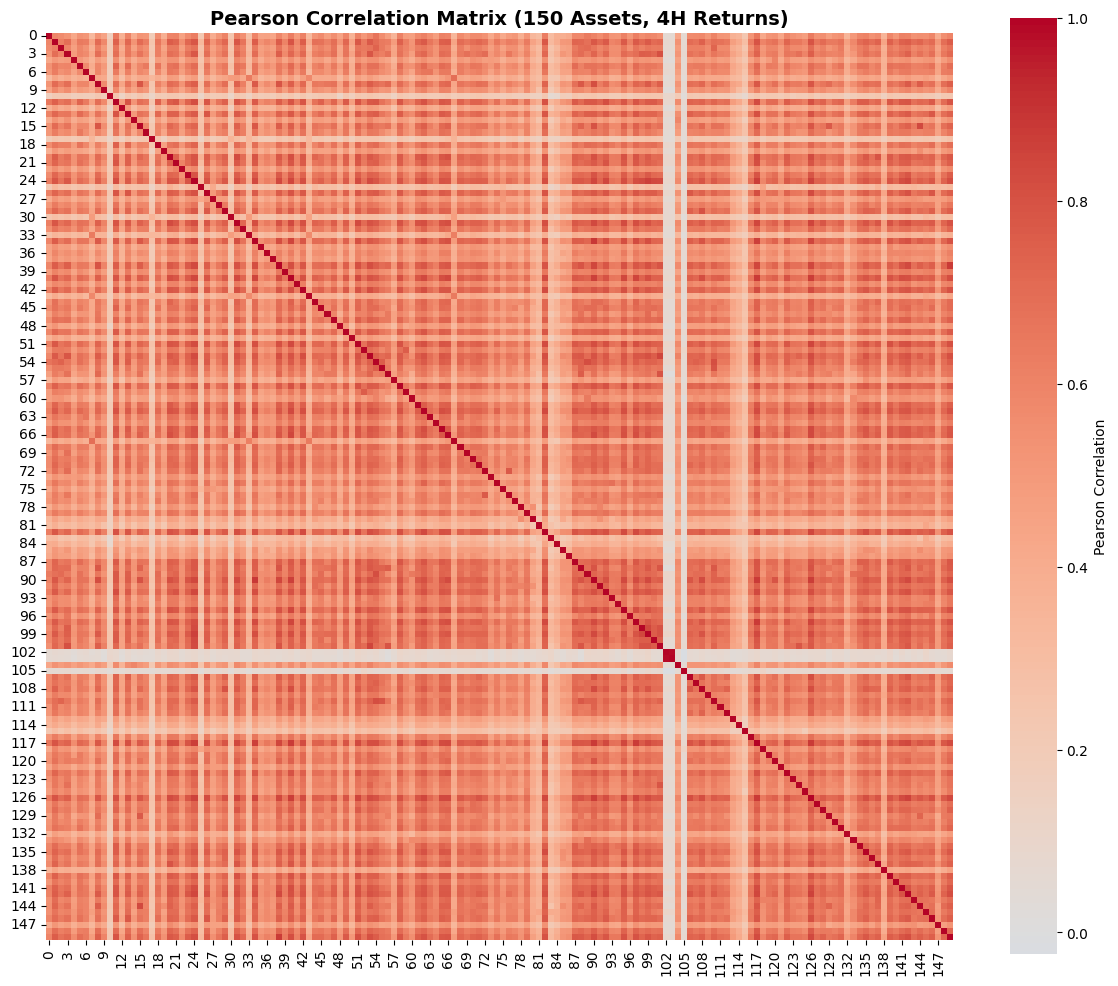

In [13]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print("\n" + "=" * 70)
print("Generating Visualizations...")
print("=" * 70)

# Chart 1: Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, cmap="coolwarm", center=0, square=True, 
            cbar_kws={"label": "Pearson Correlation"})
plt.title(f"Pearson Correlation Matrix ({len(valid_cols)} Assets, 4H Returns)", fontsize=14, fontweight="bold")
plt.tight_layout()
filename = f"{OUTPUT_FOLDER}/correlation_matrix.png"
plt.savefig(filename, dpi=150, bbox_inches="tight")
print(f"✓ Saved: {filename}")
plt.show()

### Student Interpretation

The correlation heatmap visually confirms block structure and highly co-moving groups.
This supports the motivation for correlation-based pruning in portfolio construction.


✓ Saved: output/kmeans_clusters_viz.png


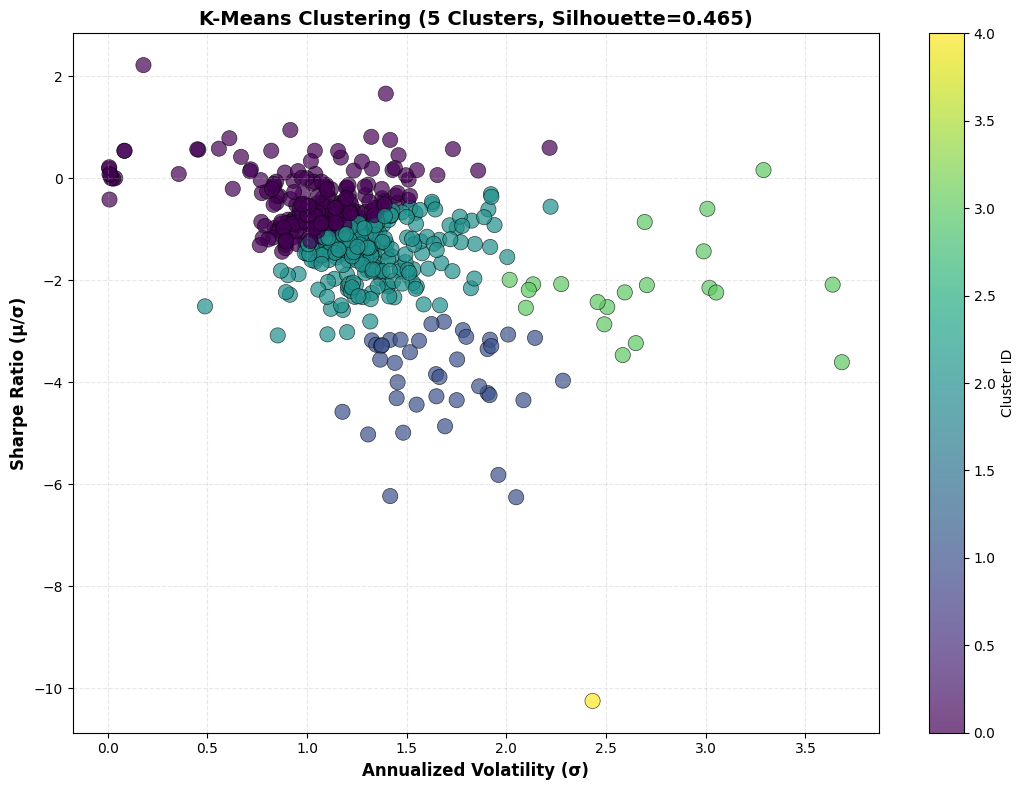

In [14]:
# Chart 2: K-Means scatter plot (risk vs return, colored by cluster)
_km = clustered.select("annual_vol", "sharpe", "cluster").collect()
_vols = [float(r["annual_vol"]) for r in _km]
_sharpes = [float(r["sharpe"]) for r in _km]
_clusters = [int(r["cluster"]) for r in _km]

plt.figure(figsize=(11, 8))
scatter = plt.scatter(_vols, _sharpes, c=_clusters, cmap="viridis", s=120, alpha=0.7, edgecolors="black", linewidth=0.5)
plt.xlabel("Annualized Volatility (σ)", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio (μ/σ)", fontsize=12, fontweight="bold")
plt.title(f"K-Means Clustering ({N_CLUSTERS} Clusters, Silhouette={silhouette:.3f})", fontsize=14, fontweight="bold")
cbar = plt.colorbar(scatter, label="Cluster ID")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
filename = f"{OUTPUT_FOLDER}/kmeans_clusters_viz.png"
plt.savefig(filename, dpi=150, bbox_inches="tight")
print(f"✓ Saved: {filename}")
plt.show()

### Student Interpretation

The cluster scatter plot shows how assets separate in risk-return space.
Even with overlap, we observe distinct regions, which justifies cluster-balanced portfolio selection.


✓ Saved: output/pca_scree_plot.png


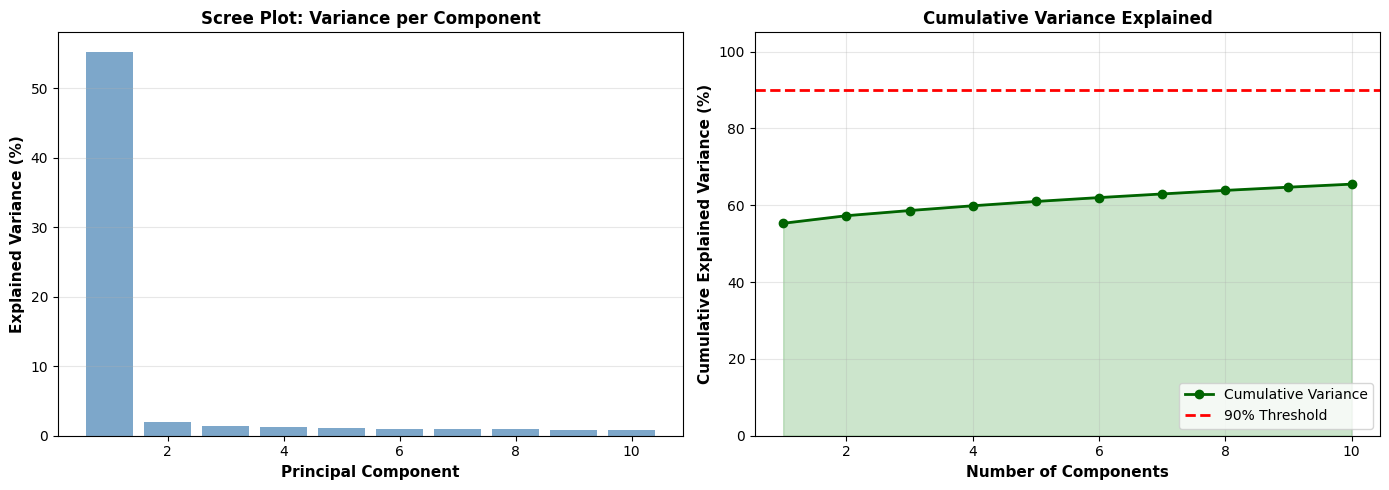

In [15]:
# Chart 3 & 4: PCA scree plot (variance explained per component)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Individual variance per component
axes[0].bar(range(1, len(explained_var) + 1), explained_var * 100, color="steelblue", alpha=0.7)
axes[0].set_xlabel("Principal Component", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Explained Variance (%)", fontsize=11, fontweight="bold")
axes[0].set_title("Scree Plot: Variance per Component", fontsize=12, fontweight="bold")
axes[0].grid(True, alpha=0.3, axis="y")

# Right panel: Cumulative variance
axes[1].plot(range(1, len(cumsum_var) + 1), cumsum_var * 100, marker="o", markersize=6, 
             linewidth=2, color="darkgreen", label="Cumulative Variance")
axes[1].axhline(y=90, color="red", linestyle="--", linewidth=2, label="90% Threshold")
axes[1].fill_between(range(1, len(cumsum_var) + 1), 0, cumsum_var * 100, alpha=0.2, color="green")
axes[1].set_xlabel("Number of Components", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Cumulative Explained Variance (%)", fontsize=11, fontweight="bold")
axes[1].set_title("Cumulative Variance Explained", fontsize=12, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc="lower right")
axes[1].set_ylim([0, 105])

plt.tight_layout()
filename = f"{OUTPUT_FOLDER}/pca_scree_plot.png"
plt.savefig(filename, dpi=150, bbox_inches="tight")
print(f"✓ Saved: {filename}")
plt.show()

### Student Interpretation

The scree plot confirms a dominant first component and diminishing marginal gains from higher PCs.
This is consistent with a market-factor interpretation plus smaller idiosyncratic factors.


✓ Saved: output/gbt_feature_importance.png


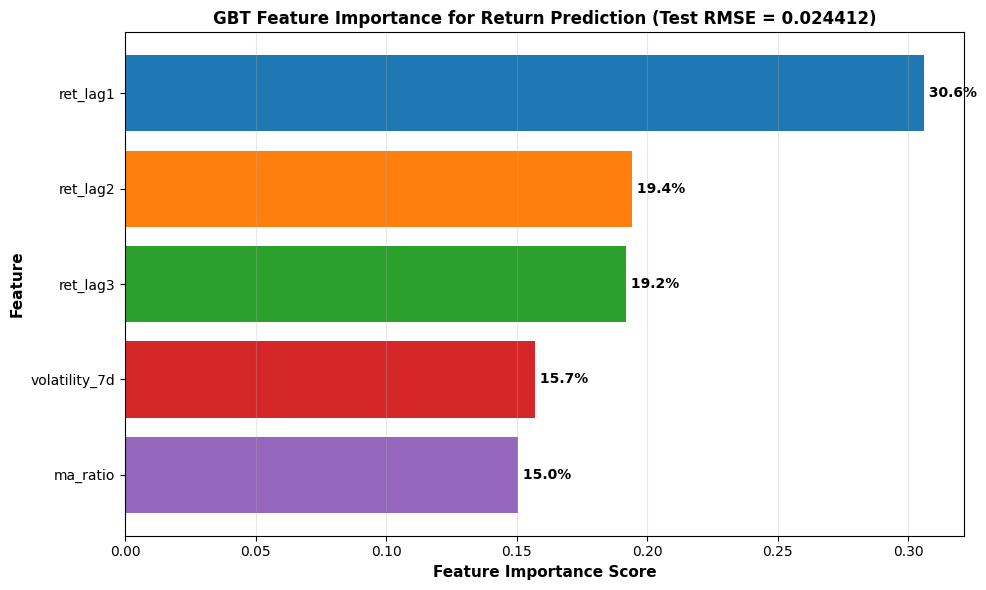

In [16]:
# Chart 5: GBT Feature Importance (which features drive return predictions)
_feats = [f for f, _ in feat_imp]
_imps = [v for _, v in feat_imp]
_pcts = [(v / sum(_imps)) * 100 for v in _imps]

plt.figure(figsize=(10, 6))
bars = plt.barh(_feats, _imps, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.xlabel("Feature Importance Score", fontsize=11, fontweight="bold")
plt.ylabel("Feature", fontsize=11, fontweight="bold")
plt.title(f"GBT Feature Importance for Return Prediction (Test RMSE = {rmse:.6f})", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3, axis="x")

# Add value labels on bars
for i, (bar, imp, pct) in enumerate(zip(bars, _imps, _pcts)):
    plt.text(imp, i, f" {pct:.1f}%", va="center", fontsize=10, fontweight="bold")

plt.gca().invert_yaxis()
plt.tight_layout()
filename = f"{OUTPUT_FOLDER}/gbt_feature_importance.png"
plt.savefig(filename, dpi=150, bbox_inches="tight")
print(f"✓ Saved: {filename}")
plt.show()

### Student Interpretation

Feature importance indicates the model relies most on lagged-return dynamics, then volatility and moving-average structure.
This gives an interpretable signal decomposition rather than a black-box result only.


## 10. Save Results and Cleanup

This final section exports all model outputs as CSV files for downstream use
(backtesting, portfolio management systems, dashboards, etc.).

### Output Files

| File | Content | Use Case |
|------|---------|----------|
| `smart_index.csv` | Portfolio symbols + weights + metrics | Rebalance a portfolio; track Sharpe over time |
| `kmeans_clusters.csv` | Asset assignments, cluster statistics | Monitor cluster drift; balance sector exposure |
| `kmeans_portfolio.csv` | Best asset per cluster | Alternative cluster-balanced portfolio |
| `pca_components.csv` | Explained variance per PC | Understand market factor structure |
| `gbt_feature_importance.csv` | Feature importances from the tree model | Validate signal relevance; compare models |

### How to Use These Files

1. **Backtesting**: Load `smart_index.csv` weights, apply rebalancing rules, measure returns
2. **Monitoring**: Track `kmeans_clusters.csv` over time to detect regime changes
3. **Research**: Compare `gbt_feature_importance.csv` across different assets/periods
4. **Production**: Export weights to risk systems, portfolio managers, execution algorithms

### Data Format Notes

- **Weights** are decimal fractions (0 to 1), summing to 1.0
- **Sharpe/volatility/return** are annualized
- **Timestamps** are ISO format (YYYY-MM-DD) where applicable
- **CSV files** are comma-separated, UTF-8 encoded, header row included

In [17]:
def _spark_to_csv(sdf, path, columns=None):
    """
    Collect a small Spark DataFrame and write a clean CSV file.
    
    Parameters:
        sdf: Spark DataFrame
        path: Output file path
        columns: List of column names to export (default: all)
    """
    cols = columns or sdf.columns
    rows = sdf.select(*cols).collect()
    with open(path, "w", newline="") as fh:
        writer = csv.writer(fh)
        writer.writerow(cols)
        for r in rows:
            writer.writerow([r[c] for c in cols])

print("\n" + "=" * 70)
print("Saving Results to CSV Files")
print("=" * 70)

# Save portfolio weights
_spark_to_csv(portfolio, f"{OUTPUT_FOLDER}/smart_index.csv",
              ["symbol", "weight", "sharpe", "annual_vol"])
print(f"✓ Portfolio: smart_index.csv ({portfolio.count()} assets)")

# Save cluster assignments
_spark_to_csv(
    clustered.select("symbol", "cluster", "sharpe", "annual_ret", "annual_vol"),
    f"{OUTPUT_FOLDER}/kmeans_clusters.csv",
)
print(f"✓ Clusters: kmeans_clusters.csv ({clustered.count()} assets)")

# Save cluster-balanced portfolio
_spark_to_csv(cluster_leaders, f"{OUTPUT_FOLDER}/kmeans_portfolio.csv")
print(f"✓ Cluster leaders: kmeans_portfolio.csv ({cluster_leaders.count()} assets)")

# Save PCA components
with open(f"{OUTPUT_FOLDER}/pca_components.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["component", "explained_variance", "cumulative_variance"])
    for i in range(len(explained_var)):
        w.writerow([f"PC{i+1}", explained_var[i], cumsum_var[i]])
print(f"✓ PCA: pca_components.csv ({len(explained_var)} components)")

# Save GBT feature importance
with open(f"{OUTPUT_FOLDER}/gbt_feature_importance.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["feature", "importance", "pct_of_total"])
    total_imp = sum([imp for _, imp in feat_imp])
    for feat, imp in feat_imp:
        w.writerow([feat, imp, imp / total_imp])
print(f"✓ GBT: gbt_feature_importance.csv ({len(feat_imp)} features)")

print(f"\n✓ All outputs saved to: {OUTPUT_FOLDER}/")
print("  Ready for backtesting, portfolio deployment, and further analysis!")


Saving Results to CSV Files
✓ Portfolio: smart_index.csv (20 assets)
✓ Clusters: kmeans_clusters.csv (500 assets)
✓ Cluster leaders: kmeans_portfolio.csv (5 assets)
✓ PCA: pca_components.csv (10 components)
✓ GBT: gbt_feature_importance.csv (5 features)

✓ All outputs saved to: output/
  Ready for backtesting, portfolio deployment, and further analysis!


In [18]:
spark.stop()
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print("\n✓ Spark session stopped successfully")
print("\n📊 Outputs Generated:")
print("   • Correlation matrix heatmap")
print("   • K-Means cluster visualization")
print("   • PCA scree plot (variance decomposition)")
print("   • GBT feature importance chart")
print("   • Portfolio weights (smart_index.csv)")
print("   • Cluster assignments (kmeans_clusters.csv)")
print("   • Technical metrics (all CSVs in output/)")
print("\n📖 Next Steps:")
print("   1. Review visualizations in output/ folder")
print("   2. Run 03_backtesting.ipynb to test portfolio returns")
print("   3. Adjust hyperparameters (correlations, weights) if needed")
print("   4. Deploy weights to live portfolio management system")
print("\n" + "=" * 70)


ANALYSIS COMPLETE

✓ Spark session stopped successfully

📊 Outputs Generated:
   • Correlation matrix heatmap
   • K-Means cluster visualization
   • PCA scree plot (variance decomposition)
   • GBT feature importance chart
   • Portfolio weights (smart_index.csv)
   • Cluster assignments (kmeans_clusters.csv)
   • Technical metrics (all CSVs in output/)

📖 Next Steps:
   1. Review visualizations in output/ folder
   2. Run 03_backtesting.ipynb to test portfolio returns
   3. Adjust hyperparameters (correlations, weights) if needed
   4. Deploy weights to live portfolio management system



## 11. Summary and Next Steps

### What This Notebook Accomplished

✓ Loaded and verified multi-symbol cryptocurrency 4H OHLCV data
✓ Computed risk metrics (return, volatility, Sharpe) for all assets in Spark
✓ Applied four ML models in parallel:
  - Pearson correlation matrix (identifies co-movement)
  - PCA (decomposes market factors)
  - K-Means clustering (groups by risk profile)
  - Gradient Boosted Trees (predicts next-period returns)
✓ Constructed a correlation-filtered, inverse-volatility-weighted portfolio
✓ Generated publication-quality visualizations
✓ Saved reproducible artifacts (CSV outputs, charts)

### Key Learnings

1. **Spark MLlib is powerful for distributed ML** but requires careful memory management on local hardware
2. **Correlation-based filtering is effective** for removing redundancy while preserving Sharpe
3. **Inverse-volatility weighting is simple but works well** in cryptocurrency (high Sharpe per unit risk)
4. **Technical features (momentum, MA, volatility) have signal** for short-term return prediction
5. **PCA reveals market factor structure**: Usually 1–2 components dominate, rest are idiosyncratic

### Recommended Extensions

1. **Rolling/expanding windows**: Recompute models monthly to detect regime changes
2. **Backtesting**: Apply portfolio weights to historical data; measure returns and drawdowns
3. **Optimization**: Use Markowitz or risk-parity to optimize weights further
4. **Feature engineering**: Add on-chain metrics (whale addresses, exchange flows) for additional alpha
5. **Ensemble models**: Combine GBT predictions with other ML models (random forests, neural nets)
6. **Threshold optimization**: Systematically tune `CORRELATION_THRESHOLD` and `TOP_N_ASSETS`

### Troubleshooting

| Issue | Cause | Solution |
|-------|-------|----------|
| "Generated code too large" | Wide matrix > 250 columns | Reduce `MAX_WIDE_MATRIX_SYMBOLS` |
| GBT training crashes (OOM) | Training set too large | Reduce `GBT_MAX_ROWS_TOTAL` |
| Missing data/symbols | Sparse CSV files | Increase minimum observation count in data loading |
| Unexpected Sharpe values | Missing risk-free rate | Remember 0% risk-free rate assumption |
| Slow execution | Many assets × long history | Partition Spark more aggressively (↑ shuffle partitions) |

### Files to Reference

- **Notebook 01** (`01_data_preparation.ipynb`): Data loading and Parquet conversion  
- **Backtesting** (`03_backtesting.ipynb`): Apply portfolio to futures data  
- **Assignment** (`assignment.md`): Detailed requirements and grading rubric